In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


import torchvision.datasets as datasets
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: Tesla T4


In [3]:
device

device(type='cuda')

In [4]:
ROOT = './data_MMNIST'

train_data = datasets.MNIST(
    root = ROOT,
    train = True,
    download=True
)

test_data = datasets.MNIST(
    root = ROOT,
    train = False,
    download=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 60.4MB/s]


Extracting ./data_MMNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data_MMNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]

Extracting ./data_MMNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_MMNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]


Extracting ./data_MMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_MMNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.61MB/s]

Extracting ./data_MMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_MMNIST/MNIST/raw



torch.Size([28, 28])


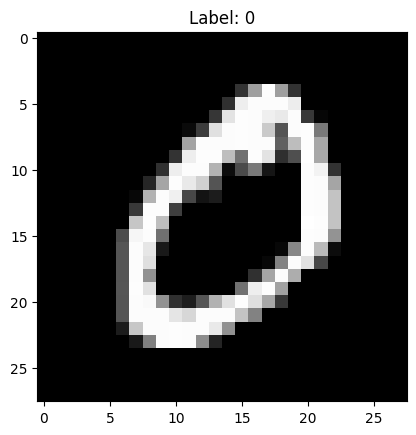

In [5]:
print(train_data.data[1].shape)
plt.imshow(train_data.data[1], cmap='gray')
plt.title("Label: " + str(train_data.targets[1].item()))
plt.show()

In [6]:
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current Device Index:", torch.cuda.current_device())

GPU Name: Tesla T4
Number of GPUs: 2
Current Device Index: 0


In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Preprocessing

In [8]:
# split data into train and validation sets with ratio 0.9 : 0.1
Valid_ratio = 0.9
n_train_samples = int(len(train_data) * Valid_ratio)
n_val_samples = len(train_data) - n_train_samples

train_data, val_data = data.random_split(train_data, [n_train_samples, n_val_samples]) # returns two datasets
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(val_data))

Number of training samples:  54000
Number of validation samples:  6000


In [9]:
# compute mean and std for normalization
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor with values in [0, 1]
    transforms.Normalize(mean=[mean], std=[std])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transform
val_data.dataset.transform = test_transform
test_data.transform = test_transform

In [10]:
# Create dataloader
batch = 256

train_loader = data.DataLoader(
    dataset = train_data,
    batch_size = batch,
    shuffle = True,
)

val_loader = data.DataLoader(
    dataset = val_data,
    batch_size = batch,
    shuffle = False,
)

test_loader = data.DataLoader(
    dataset = test_data,
    batch_size = batch,
    shuffle = False
)


# Building Models

In [11]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes= 10):
        super().__init__()

        # Convolutional layers
        CNN_layers = [
            nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            
        ]

        self.feature_extractor = nn.Sequential(*CNN_layers)

        # Fully connected layers
        layers = [
            nn.Flatten(),
            nn.Linear(32 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        ]

        self.classifier = nn.Sequential(*layers)

    def forward(self, X):
        # X: (batch_size, in_channels, height, width)
        cnn = self.feature_extractor(X)
        # cnn: (batch_size, 32, 14, 14)
        output = self.classifier(cnn)
        # output: (batch_size, num_classes)
        return output

# Training Session

In [12]:
from typing import Literal, Optional
class training_model:
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, criterion, metrics: dict[str, callable] = {"Accuracy": (accuracy_score, {})}, refit: str = "Accuracy"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics
        self.refit = refit
        self.best_model_state = None

    # Define train function
    def train_session(self):
        train_loss = 0
        total_samples = 0
        
        y_train_label_pred = []
        y_train_label_true = []

        metric_dict_train = {}

        # training session
        self.model.train()
        for X_train, y_train in self.train_loader:
            # X_train: (batch_size, in_channels, height, width)
            # y_train: (batch_size)

            y_train = y_train.to(device)
            X_train = X_train.to(device)
            
            self.optimizer.zero_grad() # reset optimizer gradients

            # forward pass
            output = self.model(X_train) # output: (batch_size, num_classes)

            # calculate loss
            loss = self.criterion(output, y_train)
            train_loss += loss.item() * len(y_train)
            total_samples += len(y_train)

            # Predictions
            y_train_label_true.extend(y_train.tolist())
            y_train_label_pred.extend(torch.argmax(output, dim=1).tolist())

            # calculate gradients
            loss.backward()

            # update weights
            self.optimizer.step()
        
        train_loss /= total_samples

        for metric_name, (metric_func, kwargs) in self.metrics.items():
            metric = metric_func(y_train_label_true, y_train_label_pred, **kwargs)
            metric_dict_train[metric_name] = metric

        return train_loss, metric_dict_train
    
    # Define validation (testing) function
    def eval_session(self, mode: Literal['Eval', 'Test'] = 'Eval'):
        # validation session
        self.model.eval()
        with torch.no_grad():
            if mode == "Eval":
                val_loss = 0
                total_samples = 0

                y_val_label_pred = []
                y_val_label_true = []

                metric_dict_val = {}
                for X_val, y_val in self.val_loader:
                    # X_val: (batch_size, in_channels, height, width)
                    # y_val: (batch_size)
    
                    y_val = y_val.to(device)
                    X_val = X_val.to(device)
                    
                    # forward pass
                    output = self.model(X_val) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_val)
                    val_loss += loss.item() * len(y_val)
                    total_samples += len(y_val)
    
                    # Predictions
                    y_val_label_true.extend(y_val.tolist())
                    y_val_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                val_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_val_label_true, y_val_label_pred, **kwargs)
                    metric_dict_val[metric_name] = metric
        
                return val_loss, metric_dict_val
            elif mode == "Test":
                test_loss = 0
                total_samples = 0

                y_test_label_pred = []
                y_test_label_true = []

                metric_dict_test = {}
                for X_test, y_test in self.test_loader:
                    # X_test: (batch_size, in_channels, height, width)
                    # y_test: (batch_size)
    
                    y_test = y_test.to(device)
                    X_test = X_test.to(device)
                    
                    # forward pass
                    output = self.model(X_test) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_test)
                    test_loss += loss.item() * len(y_test)
                    total_samples += len(y_test)
    
                    # Predictions
                    y_test_label_true.extend(y_test.tolist())
                    y_test_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                test_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_test_label_true, y_test_label_pred, **kwargs)
                    metric_dict_test[metric_name] = metric
        
                return test_loss, metric_dict_test
                

    def train(self, epochs):
        train_lossess = []
        val_lossess = []

        metric_dict_train_collect = {}
        metric_dict_val_collect = {}

        best_score = 0.0

        for epoch in range(epochs):
            score_collect = ''
            
            train_loss, metric_dict_train = self.train_session()
            val_loss, metric_dict_val = self.eval_session()

            # save loss and accuracy
            train_lossess.append(train_loss)
            val_lossess.append(val_loss)

            for metric_name, metric_value in metric_dict_train.items():
                if metric_name not in metric_dict_train_collect:
                    metric_dict_train_collect[metric_name] = []
                metric_dict_train_collect[metric_name].append(metric_value)

            for metric_name, metric_value in metric_dict_val.items():
                if metric_name not in metric_dict_val_collect:
                    metric_dict_val_collect[metric_name] = []
                metric_dict_val_collect[metric_name].append(metric_value)

                score_collect += f'- {metric_name}: {metric_value}'

                if metric_name == self.refit:
                    # Save best model based on validation F1 score
                    if metric_value > best_score:
                        best_score = metric_value
                        self.best_model_state = self.model.state_dict()
                        print("=====================")
                        print(f"Epoch {epoch+1}: New best {metric_name} on val = {best_score}, saving model...") 
                        print("=====================")

            print(f'Epoch {epoch + 1} completed - Val Loss: {val_loss} ' + score_collect) 
            

        return train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, self.best_model_state

    def test(self):
        best_model_state = self.best_model_state
        self.model.load_state_dict(best_model_state)

        score_collect = ''
        test_loss, metric_dict_test = self.eval_session(mode = "Test")
        
        for metric_name, metric_value in metric_dict_test.items():
            score_collect += f'- {metric_name}: {metric_value}'

        print(f'Test session - Test Loss: {test_loss} ' + score_collect)


In [13]:
epochs = 30
in_channels = next(iter(train_loader))[0].shape[1] # 1
num_classes = 10
model = CNN(in_channels = in_channels, num_classes = num_classes)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
training = training_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    criterion = criterion,
    metrics = {"F1 Score": (f1_score, {"average": "macro"})},
    refit = "F1 Score"
)

train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, best_model_state = training.train(epochs)

Epoch 1: New best F1 Score on val = 0.966398253081986, saving model...
Epoch 1 completed - Val Loss: 0.1139913983742396 - F1 Score: 0.966398253081986
Epoch 2: New best F1 Score on val = 0.9788598993566232, saving model...
Epoch 2 completed - Val Loss: 0.073031347711881 - F1 Score: 0.9788598993566232
Epoch 3: New best F1 Score on val = 0.979310337099322, saving model...
Epoch 3 completed - Val Loss: 0.06816376996040344 - F1 Score: 0.979310337099322
Epoch 4: New best F1 Score on val = 0.9820529436766338, saving model...
Epoch 4 completed - Val Loss: 0.0637219267586867 - F1 Score: 0.9820529436766338
Epoch 5: New best F1 Score on val = 0.9836226421711507, saving model...
Epoch 5 completed - Val Loss: 0.05841974356770516 - F1 Score: 0.9836226421711507
Epoch 6: New best F1 Score on val = 0.9852427365463405, saving model...
Epoch 6 completed - Val Loss: 0.05315571575363477 - F1 Score: 0.9852427365463405
Epoch 7 completed - Val Loss: 0.054171059504151346 - F1 Score: 0.9849607129278228
Epoch 8 

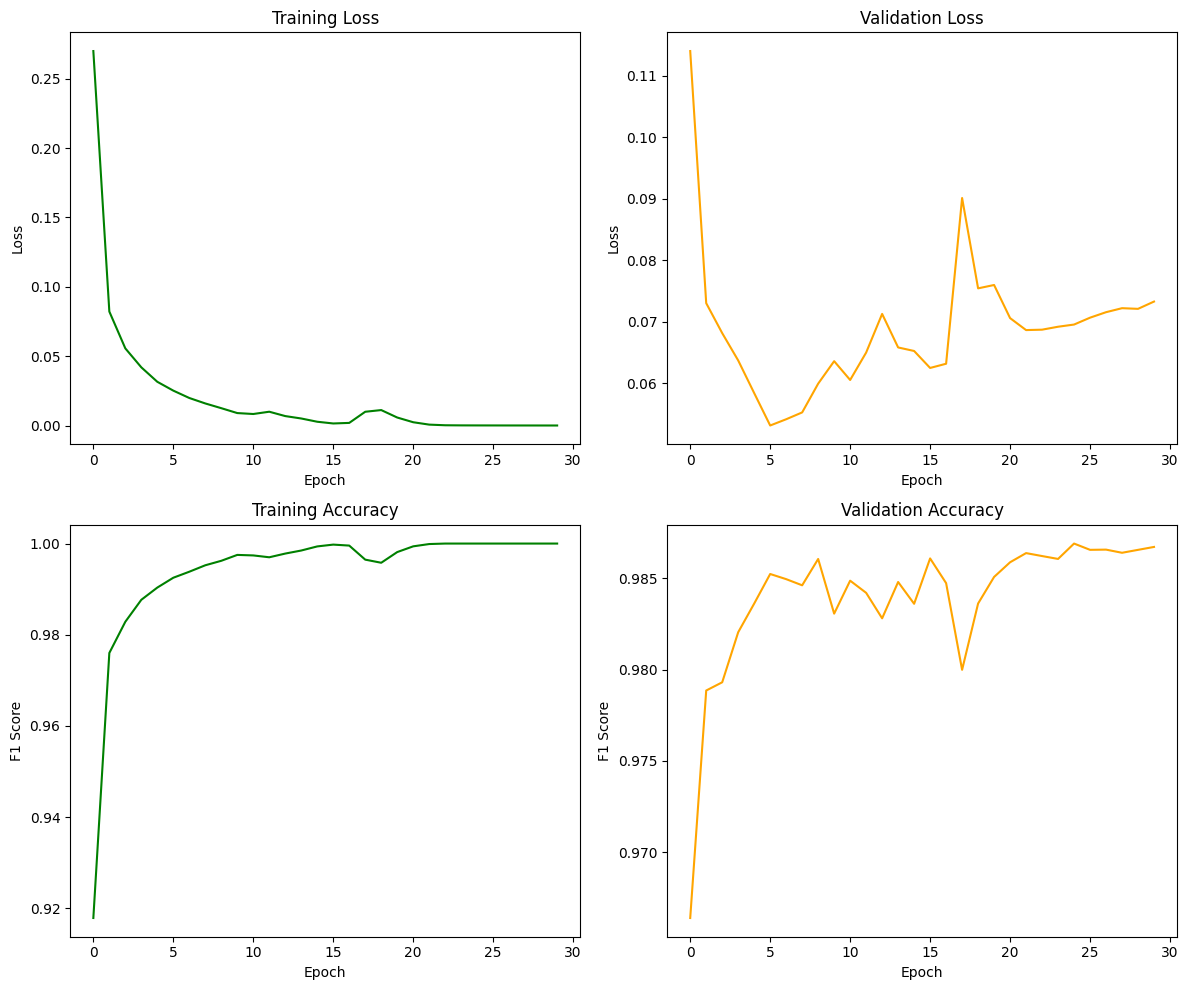

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_lossess, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_lossess, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(metric_dict_train_collect["F1 Score"], color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='F1 Score')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(metric_dict_val_collect["F1 Score"], color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='F1 Score')
ax[1, 1].set_title('Validation Accuracy')
plt.tight_layout()

plt.show()

In [16]:
training.test()

Test session - Test Loss: 0.06311849026836569 - F1 Score: 0.9870401430778507
